In [1]:
from lib.load import *
from lib.merged_dataset import *
from lib.thumbnail import *
from lib.globals import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pickle

In [2]:
train_img_names, val_img_names, test_img_names, thumbnails_dict = load()

In [3]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# print(DEVICE)
# # determine if we will be pinning memory during data loading
# PIN_MEMORY = True if DEVICE == "cuda" else False

# create the train and validation datasets
trainDS = MergedDataset(wsi_names=train_img_names, mask_thumbnails=thumbnails_dict, pseudo_epoch_length=NUM_PSEUDO_EPOCHS)
# valDS = MergedDataset(wsi_names=val_img_names, mask_thumbnails=thumbnails_dict, pseudo_epoch_length=NUM_PSEUDO_EPOCHS)
print(f"[INFO] found {len(trainDS)} samples in the merged training set...")
# print(f"[INFO] found {len(valDS)} samples in the merged validation set...")

# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True,
    batch_size=BATCH_SIZE, num_workers=4)
# valLoader = DataLoader(valDS, shuffle=False,
#     batch_size=BATCH_SIZE, num_workers=4)

Make Slide Dict: 100%|██████████| 4402/4402 [00:06<00:00, 723.44it/s]


[INFO] found 256 samples in the merged training set...


In [4]:
accumulated = torch.empty(0, dtype=torch.int8)
for e in tqdm(range(10)):
    # loop over the training set
    for (x, y) in trainLoader:
        accumulated = torch.cat((accumulated,y.flatten()))
        # print(y.flatten())
        # print(torch.bincount(y.flatten()))
    
    # Resample the pseudo epoch and refresh data loader
    trainDS.resample_pseudo_epoch()
    trainLoader = DataLoader(trainDS, shuffle=True,
                            batch_size=BATCH_SIZE, num_workers=4)

print(accumulated)
counts = torch.bincount(accumulated)
print(counts)

100%|██████████| 10/10 [01:57<00:00, 11.76s/it]


tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.int16)
tensor([ 764481893,  751793063, 1168079604])


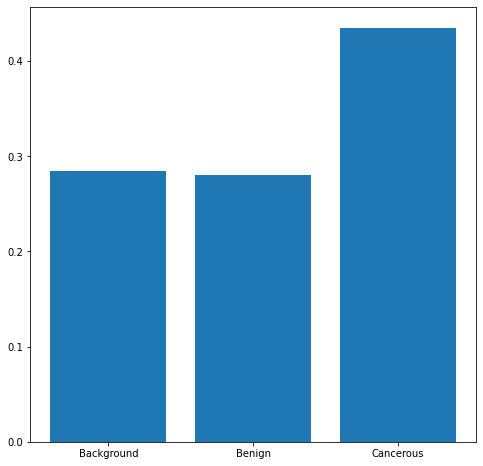

In [5]:
total = torch.sum(counts)

figure, ax = plt.subplots(1,1,figsize=(8,8))
x = np.arange(len(counts))

labels = ["Background", "Benign", "Cancerous"]

ax.bar(x,counts/total)
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()